The term vectorized backtesting refers to a technical approach to backtesting algorithmic trading strategies. Vectorized in this context refers to a programming paradigm that relies heavily or even exclusively on vectorized code. The benefits of vectorized code are more concise and easy-to-read code, as well as faster execution in many important scenarios. On the other hand, it might not be as flexible in backtesting trading strategies as event-based backtesting.

# Backtesting an SMA-Based Strategy

In [1]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
symbol = 'EUR='

In [4]:
# retrives EOD data for EUR/USD
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()[symbol])
data

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


Calculate a shorter `SMA1` for 42 days and a lonber `SMA2` for 258 days. Whenever `SMA1` is above `SMA2`, go long on the financial instrument. Whenever `SMA` is below `SMA2`, go short on the financial instrument.

<Axes: xlabel='Date'>

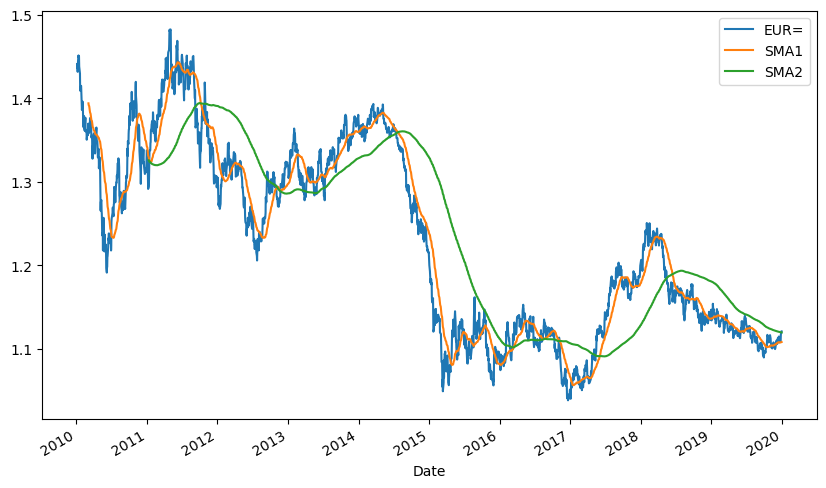

In [6]:
# calcualates the shorter SMA1
data['SMA1'] = data[symbol].rolling(42).mean()

# calculates the longer SMA2
data['SMA2'] = data[symbol].rolling(258).mean()

# visualizes the three time series
data.plot(figsize=(10, 6))

Note the shift of the resulting position time series by one day to avoid foresight bias in the data. The shift is necessary since the calculation of SMAs includes the closing values from the same day. Therefore, the position derived from the SMA values from one day needs to be applied to the next day for the whole time series.

In [7]:
# delete rows containing `NaN` values
data.dropna(inplace=True)

In [8]:
# derives the position values based on same day SMA values
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [9]:
data['p'] = data['p'].shift(1)
data.dropna(inplace=True)

<Axes: xlabel='Date'>

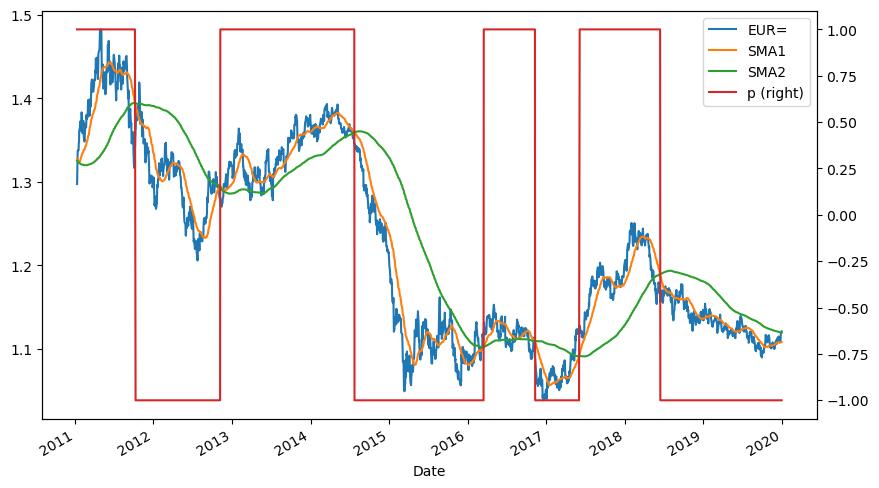

In [10]:
data.plot(figsize=(10, 6), secondary_y='p')

Once crucial step is the combination of the positions with the returns of the financial instrument. Since positions are conveniently represented by a + 1 for a long position and a - 1 for a short position, this step boils down to multiplying two columns of the `DataFrame` object.

The SMA based trading strategy outperforms the passive benchmark investment by a considerable margin.

In [11]:
# calculates the log returns
data['r'] = np.log(data[symbol] / data[symbol].shift(1))

In [12]:
data.dropna(inplace=True)

<Axes: xlabel='Date'>

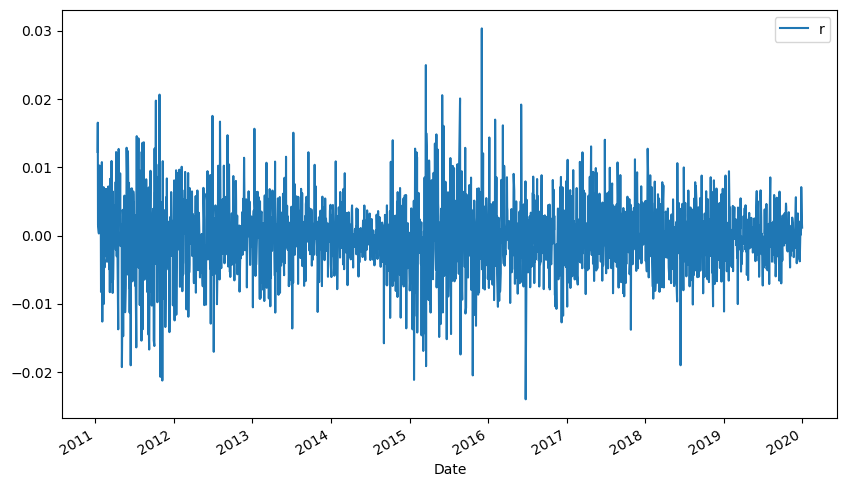

In [14]:
data[['r']].plot(figsize=(10, 6))

In [15]:
# calculates the strategy returns
data['s'] = data['p'] * data['r']

In [16]:
# calculates the gross performances
data[['r', 's']].sum().apply(np.exp)

r    0.863969
s    1.377344
dtype: float64

In [17]:
# calculates the net performances
data[['r', 's']].sum().apply(np.exp) - 1

r   -0.136031
s    0.377344
dtype: float64

<Axes: xlabel='Date'>

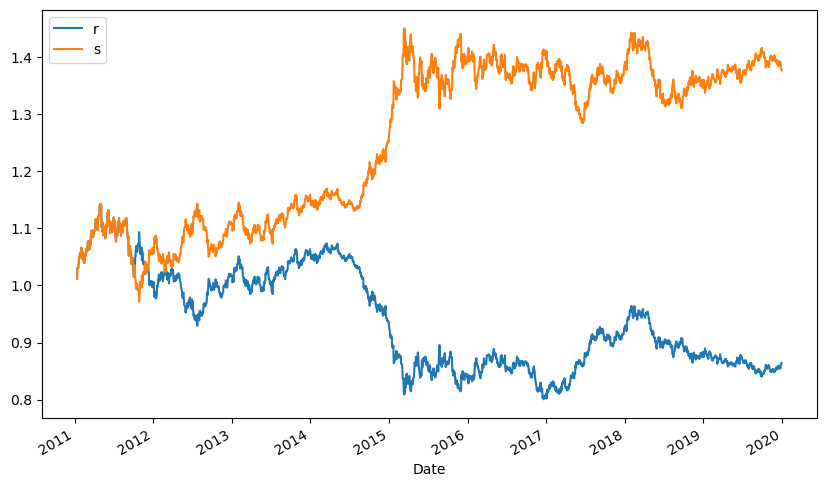

In [18]:
# visualizes the gross performances over time
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In the current setup, proportional transaction costs can be easily included in the calculations. The idea is to determine when a trade takes place and to reduce the performance of the trading strategy by a certain value to account for the relevant bid-ask spread.

In [19]:
# calculates the number of trades, including entry and exit trade
sum(data['p'].diff() != 0) + 2

10

In [20]:
# fixes the proportinal transaction costs (deliberately set quite high)
pc = 0.005

In [21]:
# adjusts the strategy performance for the transaction costs
data['s_'] = np.where(data['p'].diff() != 0, data['s'] - pc, data['s'])

In [22]:
# adjusts the strategy performance for the entry trade
data['s_'].iloc[0] -= pc

In [23]:
# adjusts the strategy performance for the exit trade
data['s_'].iloc[-1] -= pc

In [24]:
# shows the adjusted performance values for the regular trades
data[['r', 's', 's_']][data['p'].diff() != 0]

,r,s,s_
Date,,,
2011-01-12,0.012256,0.012256,0.002256
2011-10-10,0.019766,-0.019766,-0.024766
2012-11-07,-0.003362,-0.003362,-0.008362
2014-07-24,-0.000074,0.000074,-0.004926
2016-03-16,0.010211,0.010211,0.005211
2016-11-10,-0.001835,0.001835,-0.003165
2017-06-05,-0.002485,-0.002485,-0.007485
2018-06-15,0.003452,-0.003452,-0.008452


In [25]:
data[['r', 's', 's_']].sum().apply(np.exp)

r     0.863969
s     1.377344
s_    1.310171
dtype: float64

In [26]:
data[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.136031
s     0.377344
s_    0.310171
dtype: float64

<Axes: xlabel='Date'>

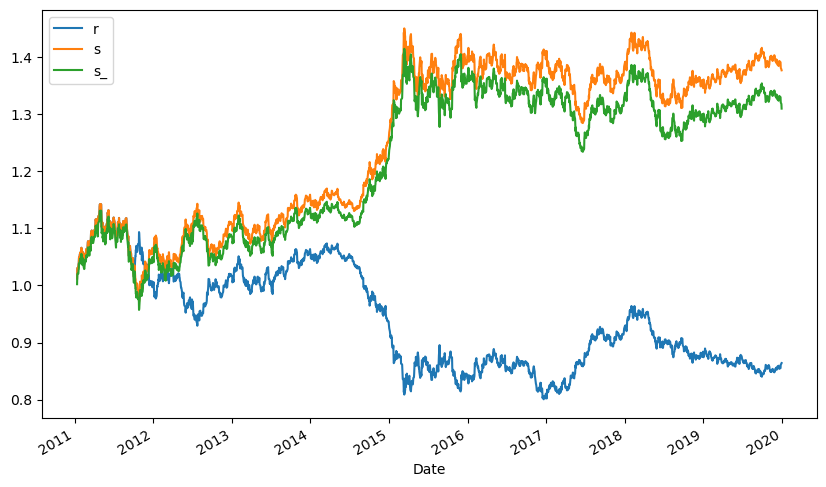

In [27]:
data[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6))

The riskm, expressed as the volatility (standard deviation of the log returns() is exactly the same as for the passive benchmark investment.

In [28]:
data[['r', 's', 's_']].std()

r     0.005375
s     0.005374
s_    0.005384
dtype: float64

In [29]:
data[['r', 's', 's_']].std() * math.sqrt(252)

r     0.085333
s     0.085309
s_    0.085472
dtype: float64

# Backtesting a Daily DNN Based Strategy



In [123]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()[symbol])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [124]:
lags = 5

In [125]:
data

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


In [126]:
data.shift(1)

,EUR=
Date,
2010-01-04,NaN
2010-01-05,1.4411
2010-01-06,1.4368
2010-01-07,1.4412
2010-01-08,1.4318
...,...
2019-12-24,1.1086
2019-12-26,1.1087
2019-12-27,1.1096


In [127]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']

    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [128]:
data, cols = add_lags(data, symbol, lags, window=20)

In [129]:
import random
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [130]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

In [131]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

In [132]:
def create_model(hl=2, hu
                 =128, dropout=False, rate=0.3,
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None

    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim, activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu', activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [133]:
# splits the data into training and test data
split = '2018-01-01'

In [134]:
train = data.loc[:split].copy()

In [135]:
# shows the frequency of the labels classes
np.bincount(train['d'])

array([ 982, 1006])

In [136]:
mu, std = train.mean(), train.std()

In [137]:
# normalizes the training features data
train_ = (train - mu) / std

In [138]:
set_seeds()
# creates the DNN model
model = create_model(hl=2, hu=64)

In [139]:
# trains the DNN model on the training data
%%time
model.fit(train_[cols], train['d'],
          epochs=20, verbose=False,
          validation_split=0.2, shuffle=False)

CPU times: user 3.63 s, sys: 150 ms, total: 3.78 s
Wall time: 5.71 s


In [140]:
# evaluates the performance of the model on the training data
model.evaluate(train_[cols], train['d'])

63/63 [==============================] - 0s 1ms/step - loss: 0.6748 - accuracy: 0.5951


[0.6748248338699341, 0.5950704216957092]

Vectorized backtesting can now be applied to judge the economic performance of the DNN-based trading strategy in-sample based on the model's predictions.

An upward prediction is naturally interpreted as a long position and a downward prediction as a short position.

In [141]:
# generates the binary predictions
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, 0)

# translates the predictions into position values
train['p'] = np.where(train['p'] == 1, 1, -1)

63/63 [==============================] - 0s 1ms/step


In [142]:
# shos the number of long and short positions
train['p'].value_counts()

-1    1125
 1     863
Name: p, dtype: int64

In [143]:
# calculates the strategy performance values
train['s'] = train['p'] * train['r']

In [144]:
# calculates the gross and net perforamances (in-sample)
train[['r', 's']].sum().apply(np.exp)

r    0.878699
s    5.377018
dtype: float64

In [145]:
train[['r', 's']].sum().apply(np.exp) - 1

r   -0.121301
s    4.377018
dtype: float64

<Axes: xlabel='Date'>

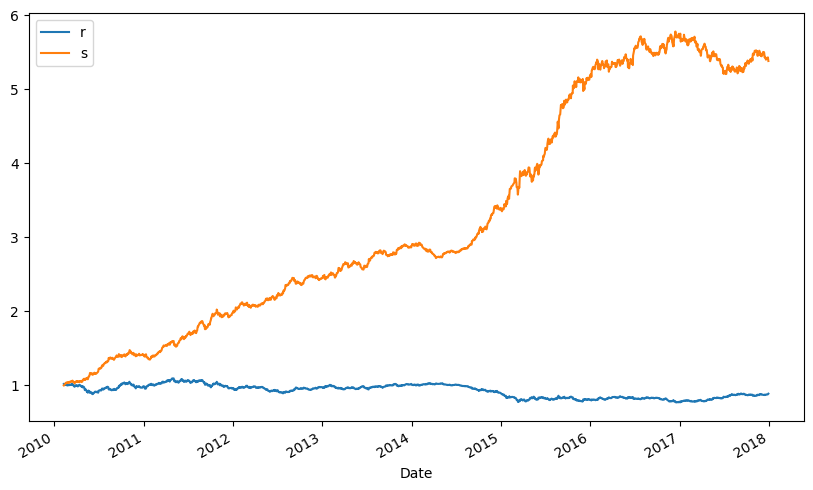

In [146]:
# visualizes the gross perforamces over time (in-sample)
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [147]:
# generates the test data sub-set
test = data.loc[split:].copy()
test_ = (test - mu) / std

In [148]:
model.evaluate(test_[cols], test['d'])

16/16 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.5149


[0.6952627897262573, 0.5149105191230774]

In [149]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

16/16 [==============================] - 0s 1ms/step


In [150]:
test['p'].value_counts()

-1    417
 1     86
Name: p, dtype: int64

In [151]:
test['s'] = test['p'] * test['r']

In [152]:
test[['r', 's']].sum().apply(np.exp)

r    0.934478
s    1.047176
dtype: float64

In [153]:
test[['r', 's']].sum().apply(np.exp) - 1

r   -0.065522
s    0.047176
dtype: float64

<Axes: xlabel='Date'>

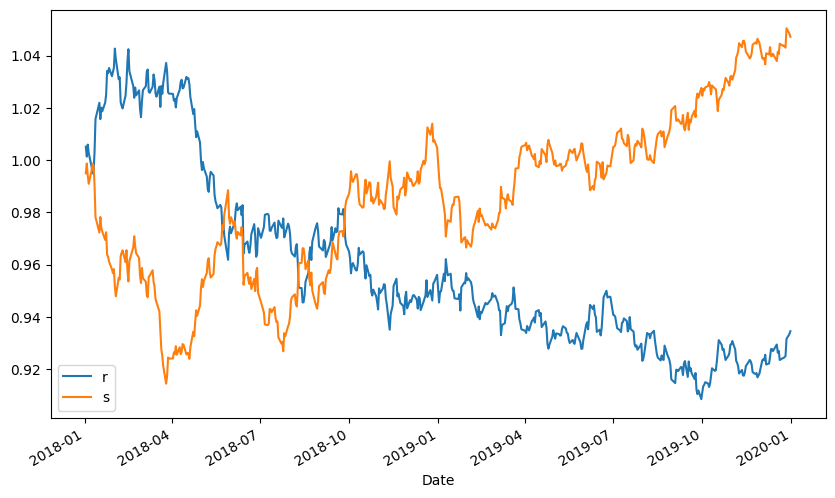

In [154]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

The DNN-based trading strategy leads to a larger number of trades as compared to the SMA based strategy.

The following code assumes realistic bid-ask spreads for EUR/USD on the level of 1.2 pips (that is, 0,00012 in terms of currency units). To simplify the calculations, an avrage value for the proportional transaction cost `pc` is calculated based on the average closing price for EUR/USD.

In [155]:
sum(test['p'].diff() != 0)

137

In [156]:
# fixes tghe average bid-ask spread
spread = 0.00012

In [157]:
# calculates the average proportional transaction costs
pc = spread / data[symbol].mean()
print(f'{pc:.6f}')

0.000098


In [158]:
test['s_'] = np.where(test['p'].diff() != 0, test['s'] - pc, test['s'])

In [159]:
test['s_'].iloc[0] -= pc

<ipython-input-159-a48dbbdc98be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_'].iloc[0] -= pc


In [160]:
test['s_'].iloc[-1] -= pc

<ipython-input-160-75c7d698d6e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_'].iloc[-1] -= pc


In [161]:
test[['r', 's', 's_']].sum().apply(np.exp)

r     0.934478
s     1.047176
s_    1.033060
dtype: float64

In [162]:
test[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.065522
s     0.047176
s_    0.033060
dtype: float64

<Axes: xlabel='Date'>

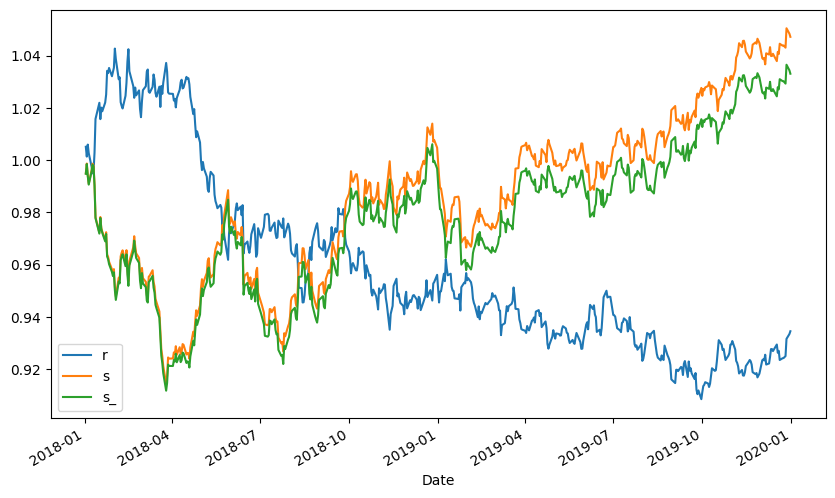

In [163]:
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6))

# Backtesting an Intraday DNN-Based Strategy

In [164]:
# retrives intraday data for EUR/USD and picks the closing prices
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR='

In [165]:
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()['CLOSE'])
data.columns = [symbol]

In [166]:
data

,EUR=
Date,
2019-10-01 00:00:00,1.0899
2019-10-01 00:01:00,1.0898
2019-10-01 00:02:00,1.0896
2019-10-01 00:03:00,1.0898
2019-10-01 00:04:00,1.0898
...,...
2019-12-31 22:11:00,1.1211
2019-12-31 23:01:00,1.1211
2019-12-31 23:03:00,1.1211


In [167]:
# resamples the data to five-minute bars
data = data.resample('5min', label='right').last().ffill()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26486 entries, 2019-10-01 00:05:00 to 2019-12-31 23:10:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    26486 non-null  float64
dtypes: float64(1)
memory usage: 413.8 KB


In [168]:
lags = 5
data, cols = add_lags(data, symbol, lags, window=20)

In [169]:
split = int(len(data) * 0.85)
train = data.iloc[:split].copy()

In [170]:
train

,EUR=,r,sma,min,max,mom,vol,d,EUR=_lag_1,EUR=_lag_2,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-01 02:10:00,1.0891,0.000184,1.089385,1.0889,1.0899,-0.000037,0.000153,1,1.0889,1.0890,...,-0.000041,-0.000041,-0.000046,-0.000032,-0.000018,0.000147,0.000147,0.000144,0.000134,0.000132
2019-10-01 02:15:00,1.0889,-0.000184,1.089335,1.0889,1.0899,-0.000046,0.000156,0,1.0891,1.0889,...,-0.000037,-0.000041,-0.000041,-0.000046,-0.000032,0.000153,0.000147,0.000147,0.000144,0.000134
2019-10-01 02:20:00,1.0888,-0.000092,1.089285,1.0888,1.0899,-0.000046,0.000156,0,1.0889,1.0891,...,-0.000046,-0.000037,-0.000041,-0.000041,-0.000046,0.000156,0.000153,0.000147,0.000147,0.000144
2019-10-01 02:25:00,1.0889,0.000092,1.089240,1.0888,1.0899,-0.000041,0.000159,1,1.0888,1.0889,...,-0.000046,-0.000046,-0.000037,-0.000041,-0.000041,0.000156,0.000156,0.000153,0.000147,0.000147
2019-10-01 02:30:00,1.0886,-0.000276,1.089175,1.0886,1.0898,-0.000060,0.000164,0,1.0889,1.0888,...,-0.000041,-0.000046,-0.000046,-0.000037,-0.000041,0.000159,0.000156,0.000156,0.000153,0.000147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-18 04:00:00,1.1133,-0.000090,1.113440,1.1131,1.1138,-0.000009,0.000112,0,1.1134,1.1133,...,-0.000018,-0.000036,-0.000036,-0.000031,-0.000031,0.000126,0.000135,0.000135,0.000141,0.000141
2019-12-18 04:05:00,1.1133,0.000000,1.113430,1.1131,1.1138,-0.000009,0.000112,0,1.1133,1.1134,...,-0.000009,-0.000018,-0.000036,-0.000036,-0.000031,0.000112,0.000126,0.000135,0.000135,0.000141
2019-12-18 04:10:00,1.1131,-0.000180,1.113405,1.1131,1.1138,-0.000022,0.000116,0,1.1133,1.1133,...,-0.000009,-0.000009,-0.000018,-0.000036,-0.000036,0.000112,0.000112,0.000126,0.000135,0.000135


In [171]:
np.bincount(train['d'])

array([16284,  6207])

In [172]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [173]:
mu, std = train.mean(), train.std()

In [174]:
train_ = (train - mu) / std

In [175]:
set_seeds()

In [176]:
model = create_model(hl=1, hu=128, reg=True, dropout=False)

In [177]:
%%time
model.fit(train_[cols], train['d'], epochs=40, verbose=False,
          validation_split=0.2, shuffle=False, class_weight=cw(train))

CPU times: user 54.4 s, sys: 3.33 s, total: 57.8 s
Wall time: 49.6 s


In [178]:
# in-sample, the performance looks promising
model.evaluate(train_[cols], train['d'])

703/703 [==============================] - 1s 1ms/step - loss: 0.5254 - accuracy: 0.6697


[0.5254268050193787, 0.6696900725364685]

In [179]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, -1)
train['p'].value_counts()

703/703 [==============================] - 1s 1ms/step


 1    11254
-1    11237
Name: p, dtype: int64

In [180]:
train['s'] = train['p'] * train['r']

In [181]:
train[['r', 's']].sum().apply(np.exp)

r    1.022316
s    1.669509
dtype: float64

In [183]:
train[['r', 's']].sum().apply(np.exp) - 1

r    0.022316
s    0.669509
dtype: float64

<Axes: xlabel='Date'>

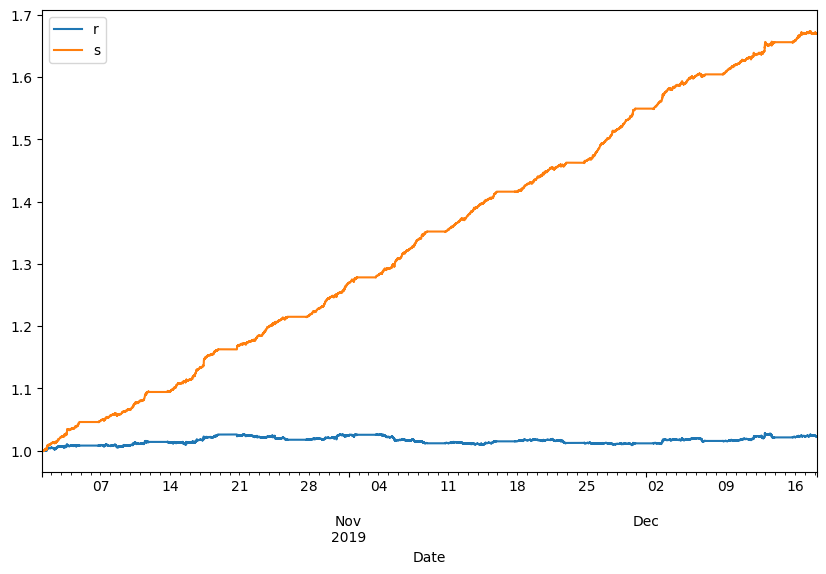

In [184]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [185]:
# out-of sample, the performance also looks promising before transaction cost
test = data.iloc[split:].copy()
test_ = (test - mu) / std

In [186]:
model.evaluate(test_[cols], test['d'])

125/125 [==============================] - 0s 1ms/step - loss: 0.5336 - accuracy: 0.6572


[0.5335637331008911, 0.6571788191795349]

In [187]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)
test['p'].value_counts()

125/125 [==============================] - 0s 1ms/step


-1    2052
 1    1918
Name: p, dtype: int64

In [188]:
test['s'] = test['p'] * test['r']

In [189]:
test[['r', 's']].sum().apply(np.exp)

r    1.007097
s    1.069363
dtype: float64

In [190]:
test[['r', 's']].sum().apply(np.exp) - 1

r    0.007097
s    0.069363
dtype: float64

<Axes: xlabel='Date'>

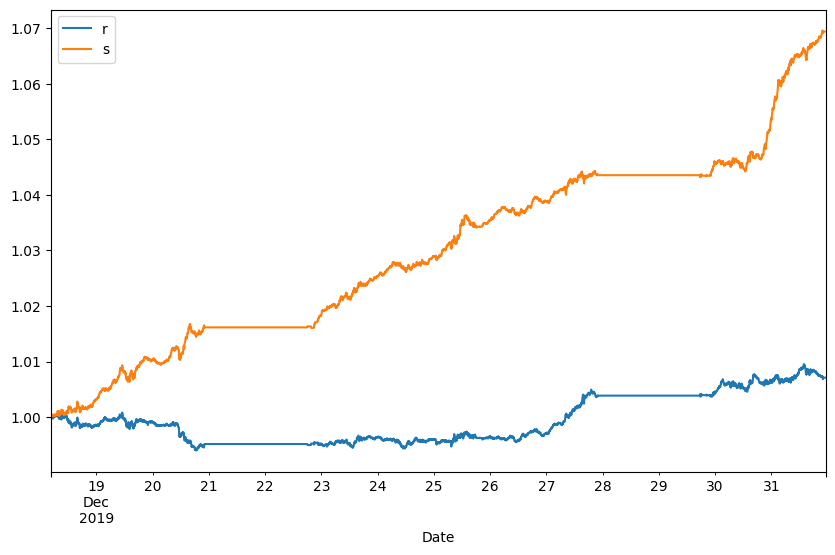

In [191]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

The final litmus test with regard to pure economic performance comes when adding transaction costs. The strategy leads to hundreds of trades over a relatively short period of time. As the following analysis suggests, based on standard retail bis-ask spreads, the DNN based strategy is not viable.

In [192]:
sum(test['p'].diff() != 0)

1231

In [194]:
# assumes bid-ask spread on retail level
spread = 0.00012
pc_1 = spread / test[symbol]
pc_1

Date
2019-12-18 04:25:00    0.000108
2019-12-18 04:30:00    0.000108
2019-12-18 04:35:00    0.000108
2019-12-18 04:40:00    0.000108
2019-12-18 04:45:00    0.000108
                         ...   
2019-12-31 22:50:00    0.000107
2019-12-31 22:55:00    0.000107
2019-12-31 23:00:00    0.000107
2019-12-31 23:05:00    0.000107
2019-12-31 23:10:00    0.000107
Freq: 5T, Name: EUR=, Length: 3970, dtype: float64

In [195]:
# assumes bid-ask spread on professional level
spread = 0.00006
pc_2 = spread / test[symbol]

In [196]:
test['s_1'] = np.where(test['p'].diff() != 0, test['s'] - pc_1, test['s'])
test['s_1'].iloc[0] -= pc_1.iloc[0]
test['s_1'].iloc[-1] -= pc_1.iloc[0]

<ipython-input-196-c177ad4fe3bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_1'].iloc[0] -= pc_1.iloc[0]
<ipython-input-196-c177ad4fe3bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_1'].iloc[-1] -= pc_1.iloc[0]


In [197]:
test['s_2'] = np.where(test['p'].diff() != 0, test['s'] - pc_2, test['s'])
test['s_2'].iloc[0] -= pc_2.iloc[0]
test['s_2'].iloc[-1] -= pc_2.iloc[0]

<ipython-input-197-26a15c8c24fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_2'].iloc[0] -= pc_2.iloc[0]
<ipython-input-197-26a15c8c24fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_2'].iloc[-1] -= pc_2.iloc[0]


In [198]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp)

r      1.007097
s      1.069363
s_1    0.936173
s_2    1.000554
dtype: float64

In [199]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp) - 1

r      0.007097
s      0.069363
s_1   -0.063827
s_2    0.000554
dtype: float64

<Axes: xlabel='Date'>

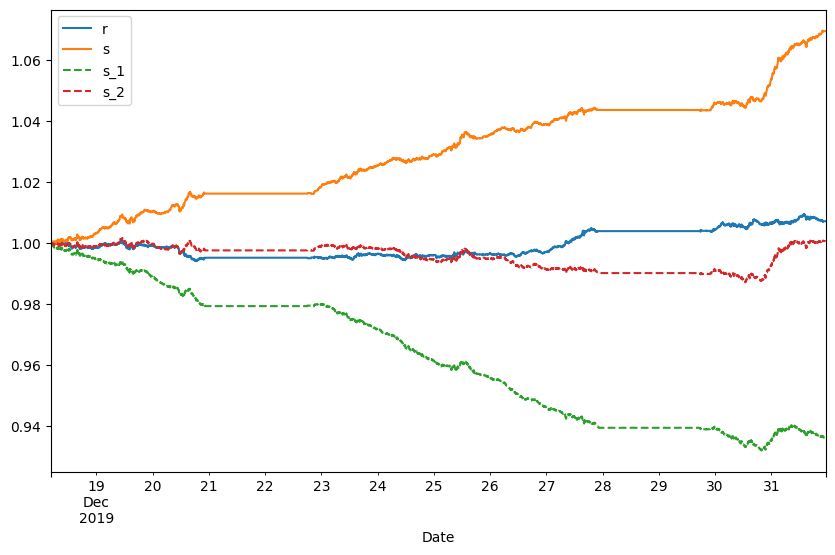

In [200]:
test[['r', 's', 's_1', 's_2']].cumsum().apply(np.exp).plot(figsize=(10, 6),
                                                           style=['-', '-', '--', '--'])